# Frequency component of swim bouts for tuning curve generation

In [1]:
import numpy as np
import math
import csv

import scipy.stats
from scipy import signal

from clam import bouts
from clam import load
from clam.utils import peakdet, smoothen
from clam.utils import filter_peaks_by_spacing

import matplotlib.pyplot as plt
%matplotlib notebook

In [71]:
def tail_beat_count(bout_start, bout_end, peak_locs, trough_locs):
    
    nbeats = []
    first_beat_loc = []
    last_beat_loc = []
    
    for i in range(len(bout_start)):
        
        startloc_r = np.argwhere(peak_locs > bout_start[i])[0]
        endloc_r = np.argwhere(peak_locs < bout_end[i])[-1]
                        
        startloc_l = np.argwhere(trough_locs > bout_start[i])[0]
        endloc_l = np.argwhere(trough_locs < bout_end[i])[-1]
        
        count_r = endloc_r - startloc_r + 1
        count_l = endloc_l - startloc_l + 1
        
        if startloc_r[0] < startloc_l[0]:
            tempf = int(peak_locs[startloc_r[0]])
        else:
            tempf = int(trough_locs[startloc_l[0]])
            
        if endloc_r[0] > endloc_l[0]:
            templ = int(peak_locs[endloc_r[0]])
        else:
            templ = int(trough_locs[endloc_l[0]])        
            
        first_beat_loc.append(tempf)
        last_beat_loc.append(templ)
        
        nbeats.append( (count_r[0] + count_l[0]) / 2 ) 
    
    return nbeats, first_beat_loc, last_beat_loc


def converttime(time):
    #offset = time & 0xFFF
    cycle1 = (time >> 12) & 0x1FFF
    cycle2 = (time >> 25) & 0x7F
    seconds = cycle2 + cycle1 / 8000.
    return seconds


def uncycle(time):
    cycles = np.insert(np.diff(time) < 0, 0, False)
    cycleindex = np.cumsum(cycles)
    return time + cycleindex * 128


def pointgrey_embedded_timestamp(pointgrey_embedded_data):
    
    with open(pointgrey_embedded_data, newline='') as csvfile:
        reader = csv.reader(csvfile)
        mdtstamp = []
        for row in reader:
            mdtstamp.append(int(row[0]))

    mdtemp = converttime(np.array(mdtstamp))
    mdtemp = uncycle(mdtemp)
    mdt = mdtemp-mdtemp[0]
    
    return mdt

## Input parameters

In [3]:
# data from tracking algorithm
saved_tracks = 'trackdata.npz'


# pointgrey embedded timestamp file
pg_md = '/home/sriram/ncbs/analysis_codes/Fictor_Analysis_Codes/data_temp/bonsai/Pointgrey_Metadata_1.csv'


# raw data saved by processing during the CL experiment
raw_cl_data_path = '/home/sriram/ncbs/analysis_codes/Fictor_Analysis_Codes/data_temp/raw/0/'


# How offset is the pointgrey timestamp from the timestamp saved in processing
t_offset = -1 # milliseconds


# minimum interval between two tail beats for pruning peak detection
minspacing = 5 #milliseconds


# Saving
savedata = True
saveas = 'boutkinematics.npz'

## Load tail tracking data

In [4]:
trackdata = np.load(saved_tracks)
endPoints = trackdata['endPoints']

pg_tstamp = pointgrey_embedded_timestamp(pg_md)

raw_cl_data = load.load_raw_data(raw_cl_data_path)

raw_tstamp = raw_cl_data['time']
raw_tstamp = [(x-raw_tstamp[0])/1000 for x in raw_tstamp]
raw_motion = raw_cl_data['movement']

pg_fps = 1/np.mean(np.diff(pg_tstamp))
t_offset = int(t_offset*1000/pg_fps)

## Distance map of endpoint of the tail from rest position

<IPython.core.display.Javascript object>


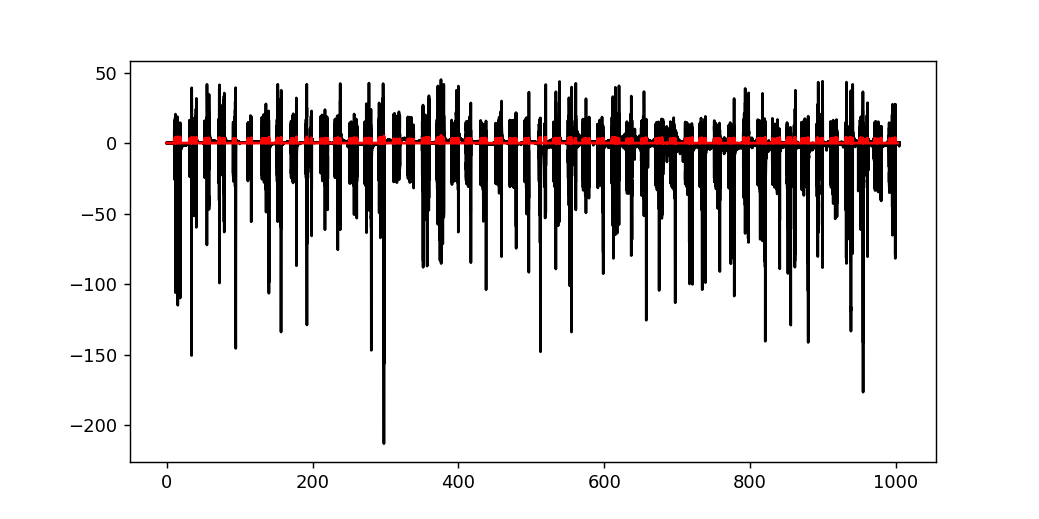

In [6]:
endX = np.median(endPoints[0][~np.isnan(np.array(endPoints[0]))])
endY = np.median(endPoints[1][~np.isnan(np.array(endPoints[1]))])

distances = [0]
d = 0
for i in range(len(endPoints[0])-1):
    
    d +=  (endPoints[0][i+1] - endPoints[0][i]) + (endPoints[1][i+1] - endPoints[1][i])
    
    distances.append(d)

distances = smoothen(distances,3)
    
plt.figure(figsize=[8,4])

plt.plot(pg_tstamp,distances, color='black')

rectified = [abs(x) for x in distances]

plt.plot(raw_tstamp,raw_motion, color='red')

## Detect inflection points that represent the peak tail beat amplitude during each swing

<IPython.core.display.Javascript object>


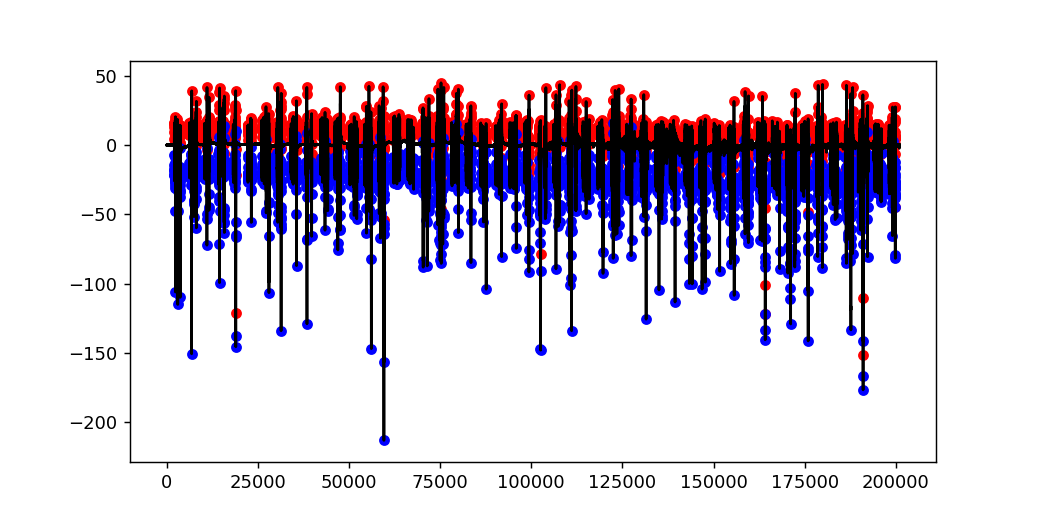

In [21]:
framespacing = int(minspacing*pg_fps/1000)

peaks,troughs = peakdet(distances, 10)

filtered_peaks = filter_peaks_by_spacing(peaks,framespacing)
filtered_troughs = filter_peaks_by_spacing(troughs,framespacing)

plt.figure(figsize=[8,4])
plt.plot(distances,color='black')
plt.scatter(filtered_peaks[:,0],filtered_peaks[:,1],s=25,color='red')
plt.scatter(filtered_troughs[:,0],filtered_troughs[:,1],s=25,color='blue')

locs = np.zeros(len(distances))
locs[filtered_peaks[:,0].astype(int)] = 1

## Calculate tail beat frequency for each swing of the tail within a bout

<IPython.core.display.Javascript object>


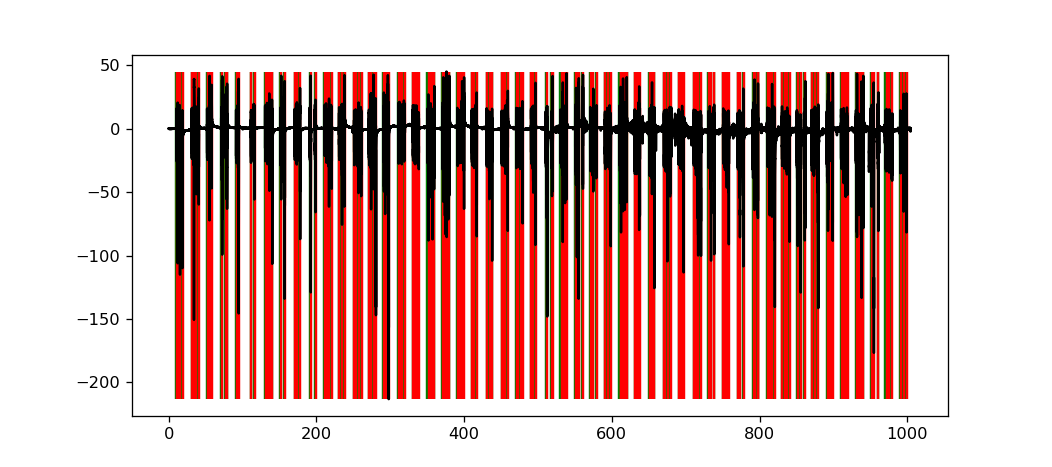

<IPython.core.display.Javascript object>


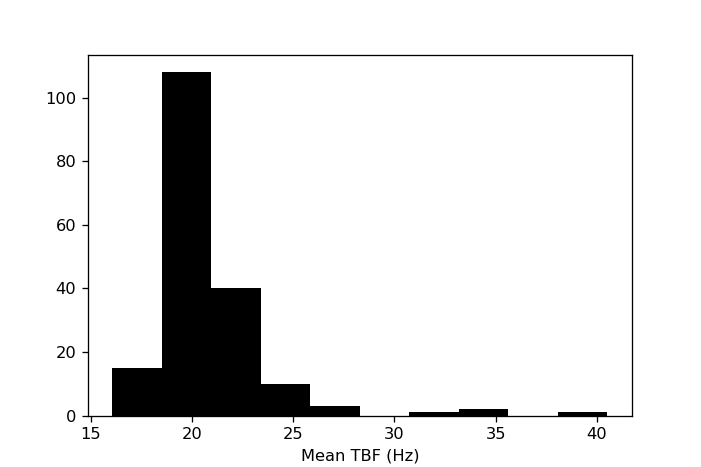

In [74]:
boutstart, boutend = bouts.bout_detect(raw_motion, max_thresh = 1.0)

start_time = [raw_tstamp[x] for x in boutstart]
end_time = [raw_tstamp[x] for x in boutend]

pg_boutstart = [np.where((np.array(pg_tstamp) <= x))[0].argmax() + t_offset for x in start_time] 
pg_boutend = [np.where((np.array(pg_tstamp) <= x))[0].argmax() + t_offset for x in end_time] 

pg_start_time = [pg_tstamp[x] for x in pg_boutstart]
pg_end_time = [pg_tstamp[x] for x in pg_boutend]


plt.figure(figsize=[9,4])
plt.plot(pg_tstamp, distances,color='black')
plt.vlines(pg_start_time, min(distances), max(distances) ,color='green')
plt.vlines(pg_end_time, min(distances), max(distances) ,color='red')

beat_count, fbi, lbi = tail_beat_count(pg_boutstart, pg_boutend, filtered_peaks[:,0], filtered_troughs[:,0])

fb_time = [pg_tstamp[x] for x in fbi]
lb_time = [pg_tstamp[x] for x in lbi]

beat_duration = [x-y for x,y in zip(lb_time,fb_time)]

duration = bouts.bout_duration([pg_boutstart,pg_boutend], pg_tstamp)
peaktimes = [pg_tstamp[int(x)] for x in filtered_peaks[:,0]]

tbf = [x/y for x,y in zip(beat_count,beat_duration)]


plt.figure(figsize=[6,4])
plt.hist(tbf, color = 'black')
plt.xlabel('Mean TBF (Hz)')

peakdiffs = list(abs(np.diff(peaktimes)))
peakdiffs.append(0)


itbf = [0]*len(pg_tstamp)

for (index,replacement) in zip(filtered_peaks[:,0], peakdiffs):
    itbf[int(index)] = replacement
    
for i in range(len(pg_boutstart)):
    endloc = int(filtered_peaks[:,0][np.where(np.array(filtered_peaks[:,0]) < pg_boutend[i])[0][-1]])
    itbf[endloc] = 0

for i in range(len(itbf)):
    if itbf[i] > 0:
        itbf[i] = 1/itbf[i]


## Transform binned tail beat frequencies to a continuous density function

<IPython.core.display.Javascript object>


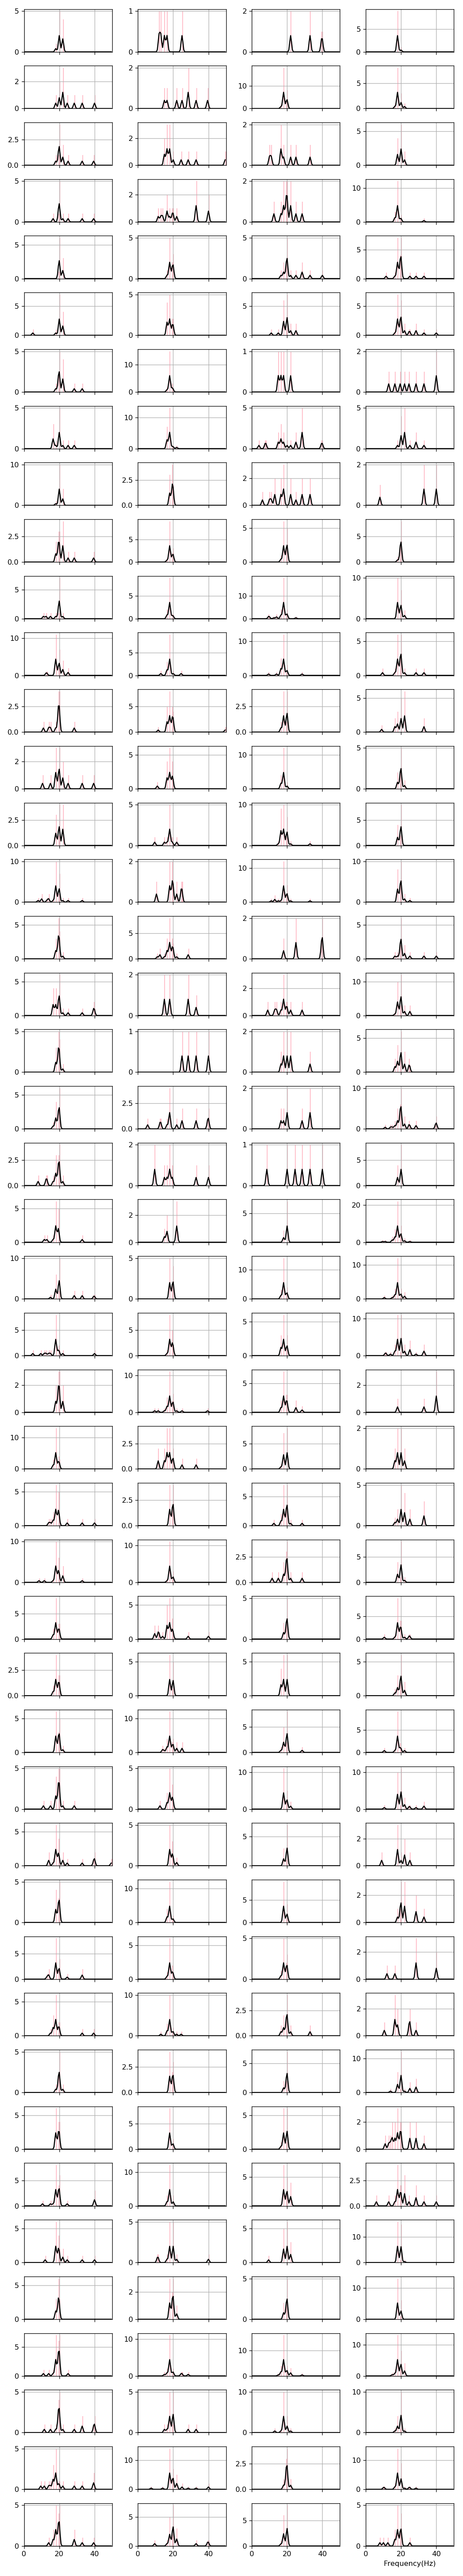

In [76]:
nbouts = len(pg_boutstart)
max_freq = 50
sigma = 0.5

binwidth = 0.5
kernel_binwidth = 0.5

kernel_edges = np.arange(-3*sigma,3*sigma+1,kernel_binwidth)
kernel = scipy.stats.norm.pdf(kernel_edges,loc=0,scale=sigma)*kernel_binwidth

normalize = False

plot = True

freq_axis = np.arange(0,max_freq,binwidth)

if plot:
    columns = 4
    plotlim = (0,max_freq)
    fig, axarr = plt.subplots(math.ceil(nbouts/columns),columns, figsize=[9,50], sharex = True)

bout_freqs = []
binned_freqs = []
cont_freqs = []

for i in range(len(pg_boutstart)):
    
    freqs = itbf[pg_boutstart[i]:pg_boutend[i]]
    freqs = [x for x in freqs if x >0]
    bout_freqs.append(freqs)
    
    hist = np.histogram(freqs,range = [0,max_freq], bins = math.ceil(max_freq/binwidth), density=normalize)
    
    if normalize:
        binned_freqs.append(list(hist[0]*binwidth))
        s = scipy.signal.convolve(hist[0],kernel,'same')*binwidth
    else:
        binned_freqs.append(list(hist[0]))
        s = scipy.signal.convolve(hist[0],kernel,'same')
        
    cont_freqs.append(s)

    if plot:
        plot_hist = axarr[i%math.ceil(nbouts/columns),
                     math.floor(i/(nbouts/columns))].hist(freqs,
                     range = [0,max_freq], bins = math.ceil(max_freq/binwidth), color = 'pink',
                                                            density=normalize)
        
        axarr[i%math.ceil(nbouts/columns),math.floor(i/(nbouts/columns))].plot(freq_axis,s, color='black')
        axarr[i%math.ceil(nbouts/columns),math.floor(i/(nbouts/columns))].set_xlim(0,max_freq)

        axarr[i%math.ceil(nbouts/columns),math.floor(i/(nbouts/columns))].grid()
        
plt.xlabel('Frequency(Hz)')
plt.tight_layout()

## Get frequency components for each bout

<IPython.core.display.Javascript object>


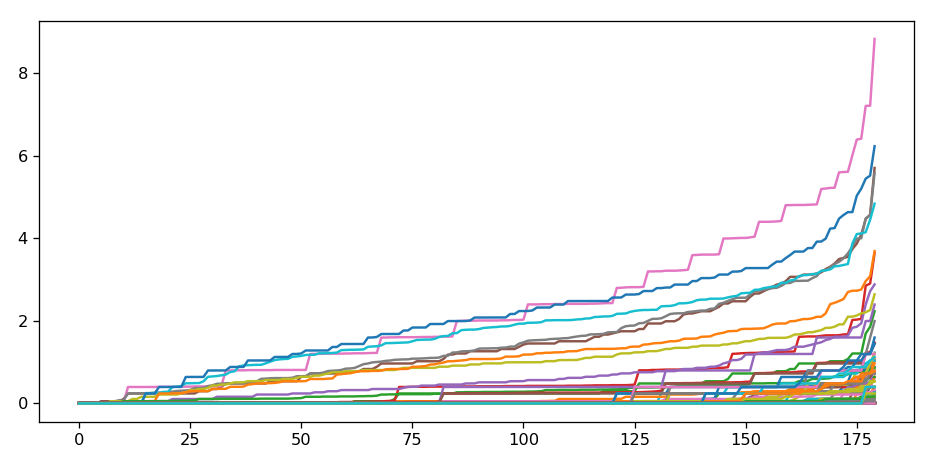

In [77]:
bout_order = []
freq_comp_sorted = []

for f in range(len(freq_axis)):
    
    f_comp = []
    for b in range(nbouts):
        f_comp.append(cont_freqs[b][f])
    
    b_order = [x for _,x in sorted(zip(f_comp,np.arange(0,nbouts,1)))]
    f_sorted = sorted(f_comp)
    
    bout_order.append(b_order)
    freq_comp_sorted.append(f_sorted)
    

plt.figure(figsize=[8,4])
for f in freq_comp_sorted:
    plt.plot(f)
    
plt.tight_layout()

## Save results

In [78]:
if savedata:
    np.savez(saveas,  mean_bout_frequency = tbf, bout_frequency_composition = cont_freqs,
             freq_axis = freq_axis, bout_order = bout_order, freq_comp_sorted = freq_comp_sorted, 
             beat_duration = beat_duration)